In [9]:
from glob import glob
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from IPython.display import Image
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB

# <font color='blue'>Motivation</font>

The ability to classify opinions into binary categories like good and bad is something that has many real world applications. Sentiment analysis is the field of study that analyzes people's opinions, sentiments, evaluations, attitudes and emotions towards entities such as products, services, organizations, individuals, issues, events, movies and topics. In simple words, it is used to track the mood of the public. It uses natural language processing and data mining techniques to the problem of extracting opinions from text. (http://www.ijettcs.org/Volume3Issue4/IJETTCS-2014-08-25-138.pdf)
The question becomes with so many classification algorithms out there how do we choose the best classifier? The motivation for us was to experiment with different classification algorithms and then build our own super classifier by using the idea behind ensemble classifiers to achieve maximum accuracy.


In Learning Word Vectors for Sentiment Analysis (Maas, Daly, et al., 2011), a vector space model that learns word
representations for capturing semantic and sentiment information was used to achieve 88% accuracy on binary classification tasks, we believe that through experiments with different classification algorithms and then by building our own super classifier by using the idea behind ensemble classifiers we can noticeably improve upon this accuracy.

## Defining the problem:

- Perform sentiment analysis on movie reviews dataset to determine polarity of each review. This task will be a binary classification problem.

- Positive review = 1
- Negative review = 0

# <font color='blue'>Data</font>

In our project we use the Large Movie Review Dataset from
- http://ai.stanford.edu/~amaas/data/sentiment/
- http://www.aclweb.org/anthology/P11-1015

Contains 25,000 highly polar movie reviews for training, and 25,000 for testing.
Reviews extracted from imdb. Training reviews are associated with labels indicating positive sentiment or negative sentiment.

# <font color='blue'>Experimental Setup</font>

We decided to use three different industry standard classification algorithms (different flavor algorithms) and then use ensemble classifiers to build a fourth classifier. The first model used was the linear SVM model which is very effective on linearly separable data like movie reviews. The second classifier used was the Naive Bayes classifier because of its independence assumption and the fact that is a strong option for applying to reviews and web discourse. The third model used was the Logistic Regression model as it works very well for modelling binary data and is one of the most commonly used models for binary classification. Lastly, we used an Ensemble method in the attempts to boost our results, by experimenting with hard and soft voting techniques to essentially aggregate our three individual classifiers. 

# <font color='blue'>Code</font>

### Builds Confusion Matrix (code was referenced)

In [10]:
#Referenced and modified from link below
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]                     #normalize the confusion matrix

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
        #plt.tight_layout()
        plt.subplots_adjust(bottom=0.4)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# <font color='blue'>Approach</font>

In [11]:
# get the location of the train and test data

path1 = './aclImdb/train/pos/*.txt'
path2 = './aclImdb/train/neg/*.txt'
path3 = './aclImdb/test/pos/*.txt'
path4 = './aclImdb/test/neg/*.txt'

files1 = glob(path1)
files2 = glob(path2)
files3 = glob(path3)
files4 = glob(path4)

In [12]:
#function that retrieves the individual reviews from each txt file and puts them all into an array 

def get_reviews(files):         
    data = []
    for name in files:
        with open(name, "r", encoding="utf-8") as f:
            single_review = f.read()
            data.append(single_review)
    return data

In [13]:
#get all the positive and negative reviews from train dataset and the same thing from the test dataset

train_pos_data = get_reviews(files1)
train_neg_data = get_reviews(files2)

test_pos_data = get_reviews(files3)
test_neg_data = get_reviews(files4)


# len(train_pos_data)
#len(train_neg_data)
#len(test_pos_data)
#len(test_neg_data)

## Exploratory Analysis

In [10]:
#print a random review so that we can visualize the raw data

train_pos_data[453]

'I first saw this movie when I was a little kid and fell in love with it at once. The sets are breath taking and some of the script is damn right hilarious: "You sons of a thousand fleas".<br /><br />It is always shown on TV late at night or really early in the morning i woke up at about 3:00 am once and it had just started. TV companys need to show a little more respect and put it on prime time Sunday so everyone can get a chance to view this fine work.<br /><br />10/10'

- reviews contain alot of repetitive words that may not help with determining sentiment on the review
- each review contains punctuation that also may not help with sentiment analysis
- there's other non-language characters that do not belong in the reviews ex. '<>' 'br'
- from quick observation of the above review we can see that noun adjectives such as 'like', 'love', and 'hate are important words for providing quick and easy indicators of whether or not a review is positive or negative

## Text Preprocessing

In [14]:
#pattern to detect the non-language characters
remove_randoms = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

#detect pattern in each review and remove it
train_pos_data = [remove_randoms.sub(" ", review) for review in train_pos_data]
train_neg_data = [remove_randoms.sub(" ", review) for review in train_neg_data]
test_pos_data = [remove_randoms.sub(" ", review) for review in test_pos_data]
test_neg_data = [remove_randoms.sub(" ", review) for review in test_neg_data]

In [15]:
# train_pos_data[453] = remove_randoms.sub(" ", train_pos_data[453])
train_pos_data[453]

'I first saw this movie when I was a little kid and fell in love with it at once. The sets are breath taking and some of the script is damn right hilarious: "You sons of a thousand fleas". It is always shown on TV late at night or really early in the morning i woke up at about 3:00 am once and it had just started. TV companys need to show a little more respect and put it on prime time Sunday so everyone can get a chance to view this fine work. 10 10'

## Build dataframe for Train dataset

- build dataframe for Train dataset
- creating a single dataframe that holds positive and negative reviews with their corresponding sentiment
- dataframes used instead of dictionary to avoid using for-loops and thus improve efficiency 

In [16]:
train_pos_df = pd.DataFrame(train_pos_data, columns=['Reviews'])
#train_pos_df.head(5)
train_pos_df["Rating"] = 1
#train_pos_df.head(5)

train_neg_df = pd.DataFrame(train_neg_data, columns=['Reviews'])
train_neg_df["Rating"] = 0
#train_neg_df.head(5)


train_df = pd.concat([train_pos_df, train_neg_df], axis=0)
#train_df.tail(5)
train_df = shuffle(train_df)      #this is done so that postive and negative reviews are not segregated in the dataset
train_df = train_df.reset_index(drop=True)
train_df.head(5)

,Reviews,Rating
0,"This film, for an after school special, isn't ...",0
1,While I certainly consider The Exorcist to be ...,0
2,I actually really like what I've seen of this ...,1
3,I cannot stay indifferent to Lars van Trier's ...,0
4,Always enjoy great films which deal with the s...,0


## Build dataframe for Test dataset

- build dataframe for Test dataset
- creating a single dataframe that holds positive and negative reviews with their corresponding sentiment
- dataframes used instead of dictionary to avoid using for-loops and thus improve efficiency 

In [17]:
test_pos_data = pd.DataFrame(test_pos_data, columns=['Reviews'])
#test_pos_data.head(5)
test_pos_data["Rating"] = 1
#test_pos_data.head(5)

test_neg_data = pd.DataFrame(test_neg_data, columns=['Reviews'])
test_neg_data["Rating"] = 0
#test_neg_data.head(5)


test_df = pd.concat([test_pos_data, test_neg_data], axis=0)
#test_df.tail(5)
test_df = shuffle(test_df)      #this is done so that postive and negative reviews are not segregated in the dataset
test_df = test_df.reset_index(drop=True)
test_df.head(5)

,Reviews,Rating
0,"If you came here, it's because you've already ...",0
1,... because while I thoroughly enjoyed this fi...,1
2,Did you ever watch a really bad movie and get ...,0
3,The rise of punk music was scarcely documented...,1
4,"Imagine Diane from Cheers, the self centered o...",0


## Split Train dataset into Train and Validation

In [18]:
X_train, X_validate, Y_train, Y_validate = train_test_split(train_df["Reviews"], train_df["Rating"], test_size=0.2)

- This image illustrates the AI training process and their different functions

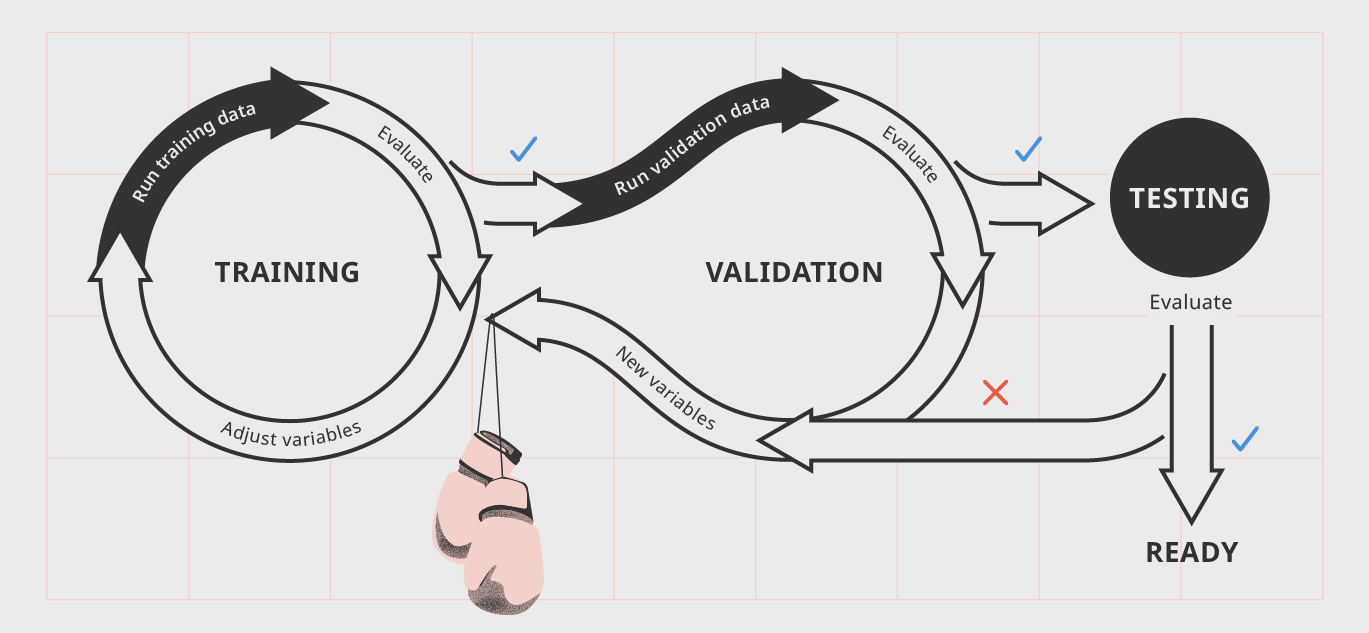

In [11]:
Image("images/dataSplitting.png")

### Why Validation?

- In machine learning we usually split data into two subsets: training and testing data and fit our model on train to then make predictions on test data
- As a result, one of two things may occur: underfitting or overfitting the model
- Underfitting creates a model that has lower accuracy and overfitting creates a model that will not be generalized to unseen data
- Instead we use training data to fit our model, then use it to predict on a validation dataset. This dataset will provide an unbiased evaluation of our model, while we tune the hyperparameters of the ML model to improve accuracy
- Finally use the test dataset to get an unbiased evaluation of the final model

## Text Data Vectorization

- need to be able to represent this text data as input for ML models because these models only understand numerical input
- do so by representing the reviews data as vectors
- the vectors are not for each word in the reviews but based on the similarities and differences between the words
- So to convert text to numerical data we will experiment with the following methods: TFIDF

### TF-IDF (Term Frequency Inverse Document Frequency)

In [19]:
#force the vectorizer to use bigram model instead of unigram
tfidf_matrix = TfidfVectorizer(ngram_range=(1, 2))

#this is the partial train data
X_train_new = tfidf_matrix.fit_transform(X_train)


#force the vectorizer to use bigram model instead of unigram
tfidf_matrix2 = TfidfVectorizer(ngram_range=(1, 2))

#this is the ENTIRE train data, which is used for the final model after tuning
X_train_new_entire = tfidf_matrix2.fit_transform(train_df['Reviews'])



#### Intuitive Definition

- to weigh down irrelevant terms and scale up the influential ones

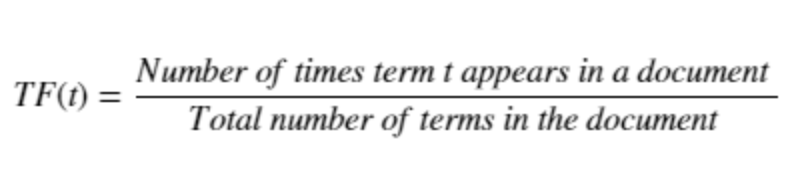

In [13]:
Image("images/tf.png")

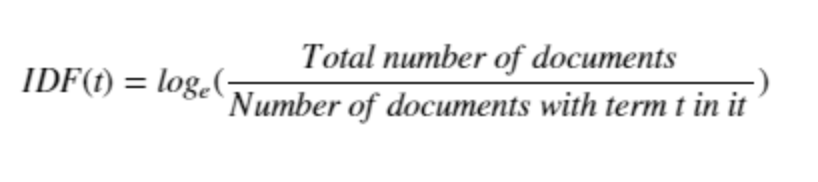

In [14]:
Image("images/idf.png")

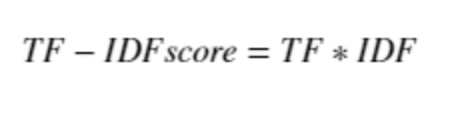

In [15]:
Image("images/tfidfEqn.png")

- The purpose of TF-IDF score can be illustrated through this graph

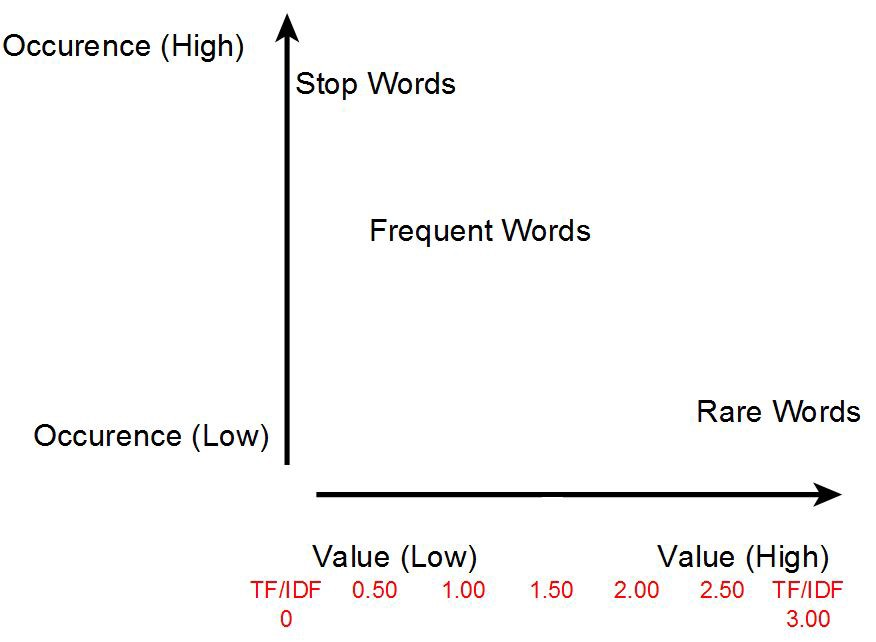

In [16]:
Image("images/tfidfGraph.jpeg")

#### Mathematical Definition

- Before vectorizing our training corpus, we create the vocabulary(index dictionary of the words from the training corpus)
- Represented below as E(t) as an example
- Column one is the indices and for each is assigned a word 't'

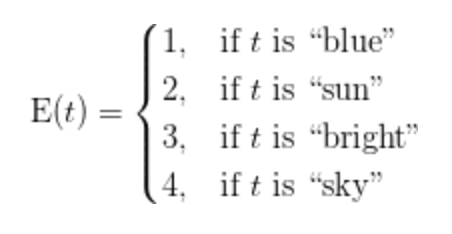

In [17]:
Image("images/wordsDictionary.png")

- Now we create a frequency dictionary which is a measure of how many times each word from our vocabulary is present in each document(review)
- Represented below as term-frequency tf(t,d)
- d = document

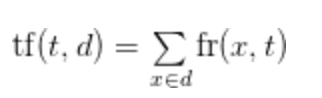

In [18]:
Image("images/tfEqn.png")

- term-frequency is calculated using a counting function fr(x,t)
- x = word from document, t = word from vocabulary

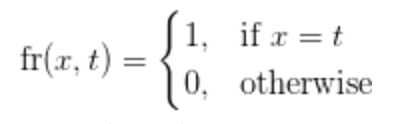

In [19]:
Image("images/simpleFunc.png")

- All reviews can be defined by the document space below

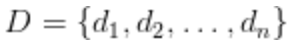

In [20]:
Image("images/docSpace.png")

- Each document will have many term-frequencies which will form the dimensions of the document vector
- Represented below is a generic vector for document 'n' and document 2,3

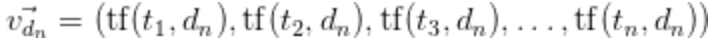

In [21]:
Image("images/docVector.png")

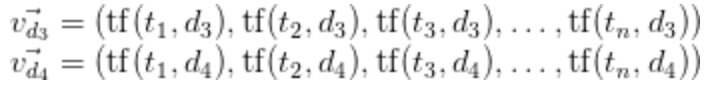

In [22]:
Image("images/docVectorEx.png")

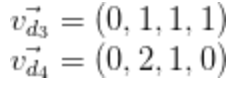

In [23]:
Image("images/docVectorResult.png")

- Each review will have its own vector
- This collection of vectors can now be represented as a matrix
- Matrix of size D by F
- D = cardinality of the document space
- F = vocabulary size(aka. number of features)

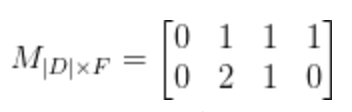

In [24]:
Image("images/docMatrix.png")

- IDF is then defined by the function idf(t)
- the denominator is the number of documents where the vocab word 't' appears
- to avoid division by zero we add 1 to the denominator

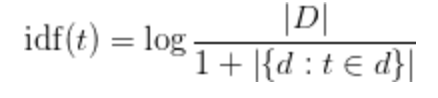

In [25]:
Image("images/idfEqn.png")

- Calculating IDF for all vocab words in our example gives the following vector

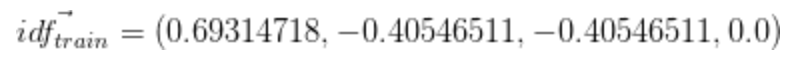

In [26]:
Image("images/idfVector.png")

- In order to match up the word values from TF and IDF and multiply them
- We need to convert IDF vector into a diagonal matrix
- Then perform matrix multiplication to get TF-IDF scores

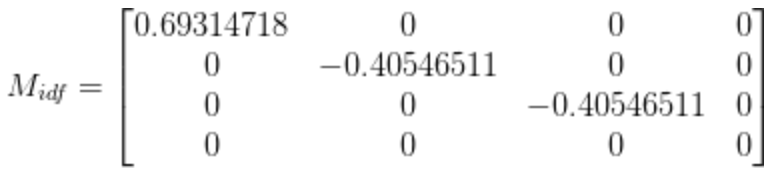

In [27]:
Image("images/idfMatrix.png")

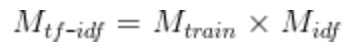

In [28]:
Image("images/tfidfEqn2.png")

## Model 1: Linear SVM (Support Vector Machine)

In [20]:
svmModel = SVC(C=1.0, kernel='linear')       #create linear SVM model
svmModel.fit(X_train_new, Y_train)        #train the model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
X_validate_new = tfidf_matrix.transform(X_validate)     #transform text validation dataset to numerical validation dataset
Y_validate_prediction = svmModel.predict(X_validate_new)        #run model on validation data

In [23]:
svmAcc = accuracy_score(Y_validate, Y_validate_prediction)          #generate accuracy score of the model
print ("Accuracy for SVM with C=%s: %s" % (1.0, svmAcc))

Accuracy for SVM with C=1.0: 0.9096


### Tuning model parameters to improve accuracy

In [24]:
for x in [0.01, 0.05, 0.25, 0.5]:         #experimenting with different regularization values 
    
    svmModel = SVC(C=x, kernel='linear')                     #create linear SVM model
    svmModel.fit(X_train_new, Y_train)                       #train the model
    X_validate_new = tfidf_matrix.transform(X_validate)      #transform text validation dataset to numerical validation dataset
    Y_validate_prediction = svmModel.predict(X_validate_new)      #run model on validation data
    svmAcc = accuracy_score(Y_validate, Y_validate_prediction)    #generate accuracy score of the model
    print ("Accuracy for SVM with C=%s: %s" % (x, svmAcc))

Accuracy for SVM with C=0.01: 0.7276
Accuracy for SVM with C=0.05: 0.8172
Accuracy for SVM with C=0.25: 0.892
Accuracy for SVM with C=0.5: 0.905


- From the above accuracy scores we conclude that using a regularization value = 1.0 results in our SVM model classifying 90.9% of the reviews correctly
- Comparing the results using different regularization values we observed that when our model chooses a hyperplane with a smaller margin it performs better
- However, we also understand that if the regularization were set to a very large value our model will overfit to our training data and not generalize well to unseen datasets
- Therefore we finalize our linear SVM model with regularization value = 1.0

### Train the final model

In [25]:
svmModel = SVC(C=1.0, kernel='linear')          #Use the model parameters that gave highest accuracy from results above 
svmModel.fit(X_train_new_entire, train_df['Rating'])     #train model on the ENTIRE train dataset
test_df_new = tfidf_matrix2.transform(test_df['Reviews'])            #transform textual test dataset to numerical test dataset

### Final result: Model 1

In [26]:
Rating_prediction = svmModel.predict(test_df_new)        #run model on test dataset
svmAcc = accuracy_score(test_df['Rating'], Rating_prediction)      #generate accuracy score of model
print ("Accuracy for SVM with C=%s: %s" % (1.0, svmAcc))

Accuracy for SVM with C=1.0: 0.90204


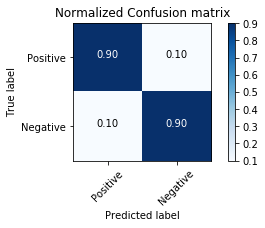

In [27]:
cnf_matrix = confusion_matrix(test_df['Rating'], Rating_prediction)         #compute confusion matrix
np.set_printoptions(precision=2)

plt.figure()
class_names = ['Positive', 'Negative']
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized Confusion matrix')     #create visualization of confusion matrix


- when performed on the test dataset Linear SVM had an accuracy score of 90.2% 

#### Intuitive Definition

- SVM is a supervised learning method used for many applications but here it will be used specifically for Binary Sentiment Analysis
- There are different kernel functions that can used for SVM but here we will discuss the 'Linear' kernel
- This model is very effective on linearly seperable data, which is why we are using it
- Linear Seperability can be defined as two subsets that have a decision boundary that seperates the elements of each set
- In our case, all postive reviews will be on one side of the hyperplane and negative reviews on the opposite side
- Below is a visual representation of linear classification, in this case the decision boundary is linear on a 2-dimensional dataset

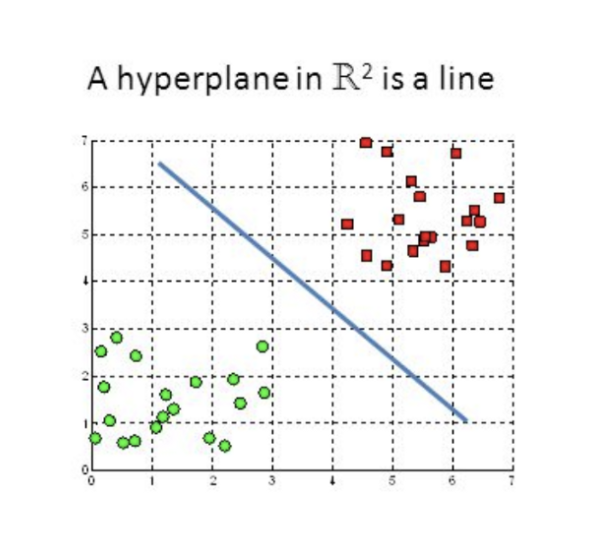

In [3]:
Image("images/2dGraph.png")

#### Mathematical Definition

- Below is a mathematical definition of linear seperability
- H = positive reviews, M = negative reviews
- This expression states that H and M are linearly separable if there exists a hyperplane that completely separates the elements of H and elements of M

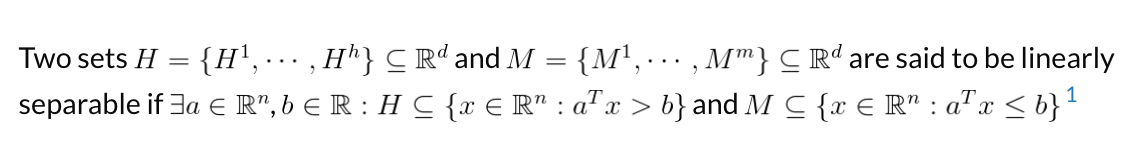

In [4]:
Image("images/linearSepDef.png")

- Objective of SVM is to find a hyperplane in N-dimensional space that clearly seperates the two classes of data points
- N = features which in our case is the words
- This means N will be very large, and there will be too many hyperplanes to chose from
- However, the goal is to find the plane that has the maximum distance between data points of both classes, represented in the second graph below

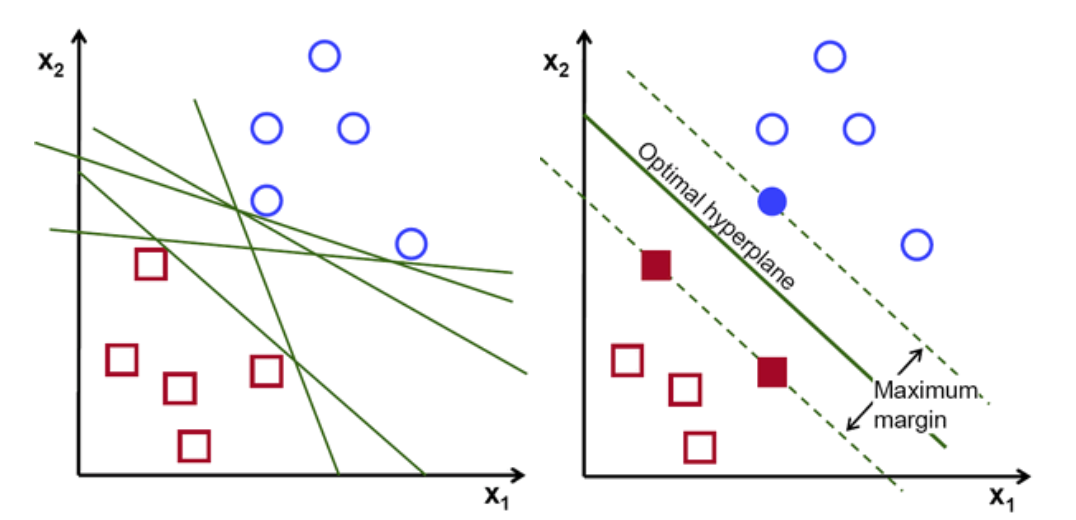

In [5]:
Image("images/hyperplanes.png")

- Hyperplanes are not always just a line
- Graphs so far have depicted 2-dimensional data which have 2 features 
- In our case we will have thousands of features, each representing a word
- Graphical representation of such a high dimensional space is not possible so we present a 3-dimensional space to give an idea of how the hyperplane changes form
- Below the hyperplane becomes a 2-dimensional plane

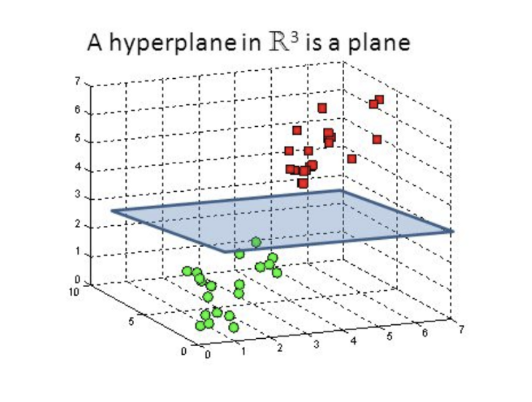

In [6]:
Image("images/3dGraph.png")

##### Kernel parameter
- Support vectors are the data points that are near the hyperplane that influence the positioning and its orientation
- Using these support vectors we maximize the margin
- Classifying these support vectors is done by a decision function
- Below is a decision function for our linear kernel
- It outputs values ranging from -1 to 1, based on the sign of the output the data point will go on one side of the hyperplane

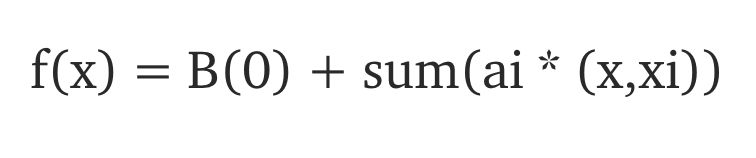

In [7]:
Image("images/decisionFunc.png")

- x = input vector, support vector = xi, B(0) and 'ai' are coefficients
- this function performs the inner products of 'x' with all the support vectors in the training data
- while the coefficients are both estimated from the training data by the learning algorithm

##### Regularization parameter
- Represented as 'C' in the python SVM function
- This parameter tells the SVM opitimizer how much to avoid misclassifying training data
- If C is very large, optimizer chooses hyperplane with smaller margin
- If C is very small, optimizer chooses hyperplane with larger margin
- Left graph shows a low regularization value
- Right graph shows a high regularization value

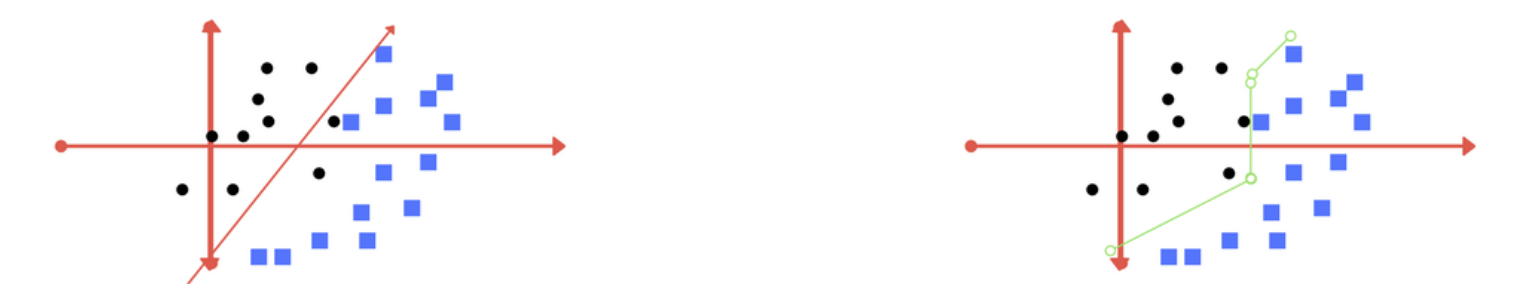

In [8]:
Image("images/regularization.png")

## Model 2: Logistic Regression

The logistic regression model or log-linear classifier is used to estimate the probability of an event occurring having been given some previous data. 

In this model, the probabilities describing the possible outcomes are modeled using the logistic sigmoid function
 ![image.png](images/log2.png)

In [14]:
#train logistic regression model
logModel = LogisticRegression()
logModel.fit(X_train_new, Y_train)

#extract tf-idf features from validation data
X_validate_new = tfidf_matrix.transform(X_validate)

#predict class label
Y_validate_prediction = logModel.predict(X_validate_new)

#print accuracy of predicted class label to actual class label of the validation data set
logModelAcc = accuracy_score(Y_validate, Y_validate_prediction)
print ("Accuracy for Logistic Regression: %s" % (logModelAcc))

Accuracy for Logistic Regression: 0.8902


As we can see, the logistic regression model predicts the correct sentiment class label 89% of the time for the validation dataset, this accuracy is quite good, but lets see if we can do better by tuning the model parameters.

### Tuning model parameters to improve accuracy

Regularization is when we apply a penalty/bias to the cost function in order to reduce overfitting.

In sklearn's default implementation of Logistic Regression which we are currently using, we minimize the following cost function using the coordinate descent algorithm:
![image.png](images/log1.png)

We need to tune the regularization parameter C to give the best generalization performance/accuracy. Minimizing overfitting while also avoiding underfitting. This means that when a good regularization parameter is chosen the model should then be able to generalize well to new, unseen data.

The optimal way of finding the best paramaters would be to use grid search, but since it is very time consuming instead we will just test the most common parameters to see which works best for our model. 

In [15]:
 for x in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
     logModel = LogisticRegression(C=x)
     logModel.fit(X_train_new, Y_train)
     X_validate_new = tfidf_matrix.transform(X_validate)
     Y_validate_prediction = logModel.predict(X_validate_new)
     logModelAcc = accuracy_score(Y_validate, Y_validate_prediction)
     print ("Accuracy for Logistic Regression with C=%s: %s" % (x, logModelAcc))


Accuracy for Logistic Regression with C=0.001: 0.7466
Accuracy for Logistic Regression with C=0.01: 0.8076
Accuracy for Logistic Regression with C=0.1: 0.8458
Accuracy for Logistic Regression with C=1: 0.8902
Accuracy for Logistic Regression with C=10: 0.907
Accuracy for Logistic Regression with C=100: 0.91
Accuracy for Logistic Regression with C=1000: 0.9124


We can see that C=1000 results in the highest accuracy of 91.2%, so let us use that as our final tuned parameter.

### Final result: Model 2

Final Accuracy for Logistic Regression with C=1000: 0.90248


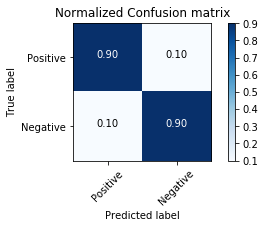

In [20]:
# Train the final model
logModelFinal = LogisticRegression(C=1000)          #Use the model parameters that gave highest accuracy from results above 
logModelFinal.fit(X_train_new_entire, train_df['Rating'])     #train model on the ENTIRE train dataset
test_df_new = tfidf_matrix2.transform(test_df['Reviews'])

#Predict and display results
Rating_prediction = logModelFinal.predict(test_df_new)
logModelFinalAcc = accuracy_score(test_df['Rating'], Rating_prediction)

cnf_matrix = confusion_matrix(test_df['Rating'], Rating_prediction)                                  #Compute confusion matrix
np.set_printoptions(precision=2)

plt.figure()
class_names = ['Positive', 'Negative']
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized Confusion matrix')
print ("Final Accuracy for Logistic Regression with C=%s: %s" % (1000, logModelFinalAcc))

After training the model on the entire training set and predicting class labels for the test set we get a final accuracy of 90.2% correctly classified reviews on the imdb movie review test set.

- F1 score = 0.9
- precision = 0.9
- recall = 0.9

## Model 3: Multinomial Naive Bayes

To determine the classification of a given movie review, the general idea is to use Bayes theorem to determine the argmax probability of class given the hypothesis h where h depends on the attribute values of x

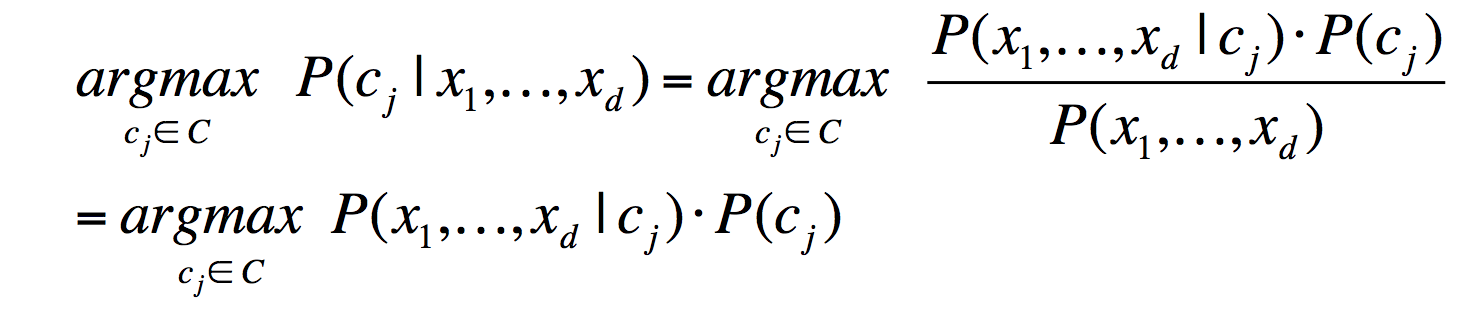

In [4]:
Image("images/bayesianclassifier.png")

The assumption of the Naive Bayes classifier is that attribute values xi are conditionally independent given class cj. The advantage is that P(xi}cj) are easier to estimate from the training data than P(x1,...,xd|cj). This also means instaed of having to estimate |A1| * .. |Ad\ parameters, we only have to estimate |A1|+...|+|Ad| parameters.

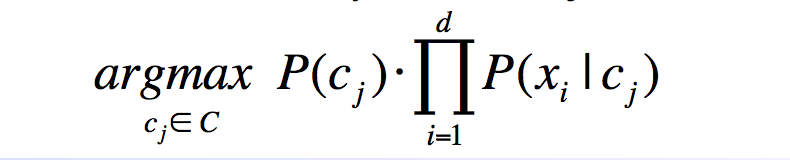

In [5]:
Image("images/naivebayesdecisionrule.png")

To estimate the P(xi|cj), we can simply use the maximum likelihood estimate. Meanwhile the P(cj) can be estimated using the observed frequencies of the individual classes.

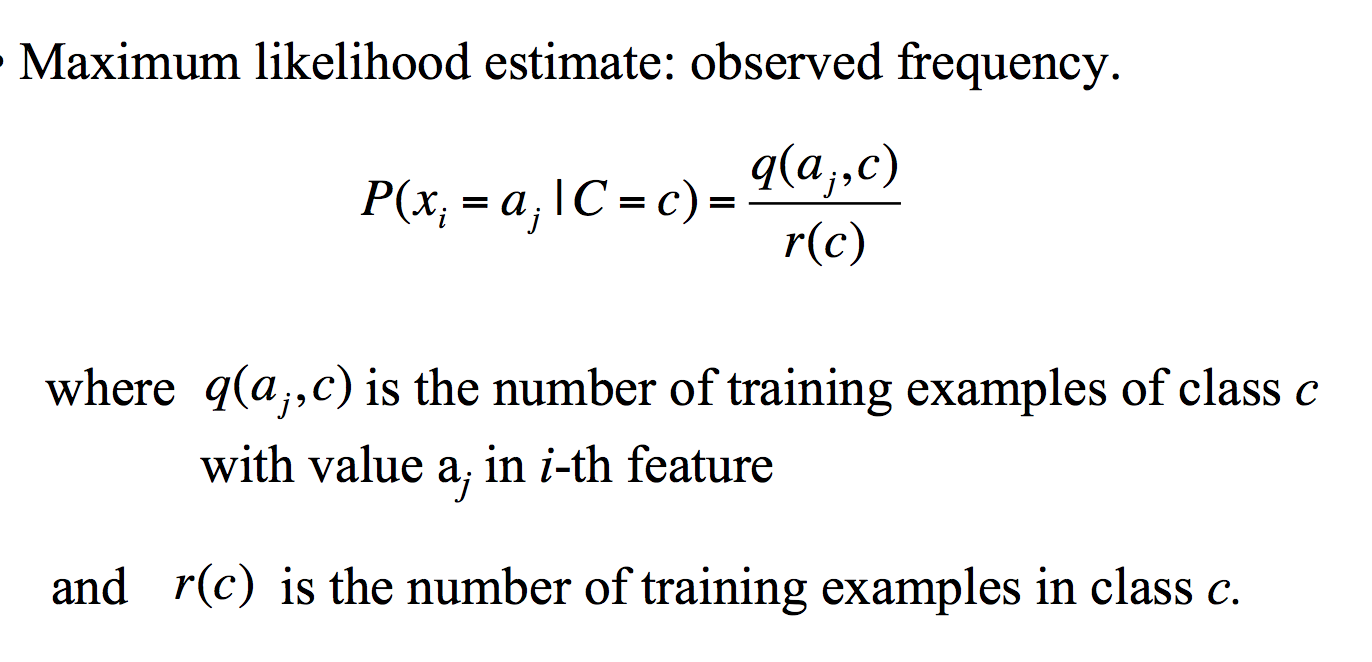

In [21]:
Image("images/maximumlikelihoodestimate.png")

In [18]:
#train Naive Bayes model
nbModel= MultinomialNB()
nbModel.fit(X_train_new, Y_train)

#extract tf-idf features from validation data
X_validate_new = tfidf_matrix.transform(X_validate)

#predict class label
Y_validate_prediction = nbModel.predict(X_validate_new)

#print accuracy of predicted class label to actual class label of the validation data set
nbModelAcc = accuracy_score(Y_validate, Y_validate_prediction)
print ("Accuracy for Logistic Regression: %s" % (nbModelAcc))

Accuracy for Logistic Regression: 0.8884


### Tuning model parameters to improve accuracy

In [19]:
X_validate_new = tfidf_matrix.transform(X_validate)
for x_alpha in [1e-10,1e-09,1e-08,1e-07,1e-06,1e-05,1e-04,1e-03,1e-02,1e-01,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:    
    nbModel = MultinomialNB(alpha=x_alpha)
    nbModel.fit(X_train_new, Y_train)
    X_nb_validate_new = tfidf_matrix.transform(X_validate)
    Y_nb_validate_prediction = nbModel.predict(X_nb_validate_new)
    nbAcc = accuracy_score(Y_validate, Y_nb_validate_prediction)
    print ("Accuracy for NB with alpha=%s: %s" % (x_alpha, nbAcc))

Accuracy for NB with alpha=1e-10: 0.8414
Accuracy for NB with alpha=1e-09: 0.8442
Accuracy for NB with alpha=1e-08: 0.8484
Accuracy for NB with alpha=1e-07: 0.8526
Accuracy for NB with alpha=1e-06: 0.8574
Accuracy for NB with alpha=1e-05: 0.8638
Accuracy for NB with alpha=0.0001: 0.8738
Accuracy for NB with alpha=0.001: 0.8848
Accuracy for NB with alpha=0.01: 0.896
Accuracy for NB with alpha=0.1: 0.8998
Accuracy for NB with alpha=0.2: 0.8968
Accuracy for NB with alpha=0.3: 0.8956
Accuracy for NB with alpha=0.4: 0.893
Accuracy for NB with alpha=0.5: 0.8922
Accuracy for NB with alpha=0.6: 0.8912
Accuracy for NB with alpha=0.7: 0.8904
Accuracy for NB with alpha=0.8: 0.8902
Accuracy for NB with alpha=0.9: 0.8886
Accuracy for NB with alpha=1: 0.8884


### Train the final model

Final Accuracy for Naive Bayes with Alpha=0.1: 0.86716


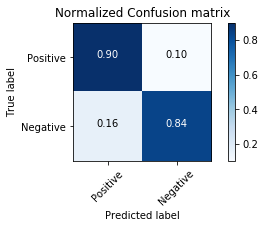

In [20]:
# Train the final model
nbModelFinal = MultinomialNB(alpha=0.1)          #Use the model parameters that gave highest accuracy from results above 
nbModelFinal.fit(X_train_new_entire, train_df['Rating'])     #train model on the ENTIRE train dataset
test_df_new = tfidf_matrix2.transform(test_df['Reviews'])

#Predict and display results
Rating_prediction = nbModelFinal.predict(test_df_new)
nbModelFinalAcc = accuracy_score(test_df['Rating'], Rating_prediction)

cnf_matrix = confusion_matrix(test_df['Rating'], Rating_prediction)                                  #Compute confusion matrix
np.set_printoptions(precision=2)

plt.figure()
class_names = ['Positive', 'Negative']
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized Confusion matrix')
print ("Final Accuracy for Naive Bayes with Alpha=%s: %s" % (0.1, nbModelFinalAcc))

## Model 4: Ensemble Method

- There are two families of ensemble methods: averaging and boosting
- We will be implementing the averaging method
- In our design the purpose of this model was to build three models independently and then to average their predictions
- On average the combined model usually performs better than any single model because its variance is reduced
- The Voting Classifier can be tuned to implement hard or soft voting
- Hard voting is when the prediction for a dataset is the class label that represents the majority of the class labels predicted by each individual classifier.
- Soft voting uses specific weights assigned to each classifier and then the predictions for each classifier are collected, multiplied by the classifier weight, and averaged

In [12]:
all_models = [("Linear SVM", SVC(C=1.0, kernel='linear')), 
               ("Multinomial Naive Bayes", MultinomialNB(alpha=0.1)), 
               ("Logistic Regression", LogisticRegression(C=1000))]

### Hard Voting

In [14]:
hard_model = VotingClassifier(all_models, voting='hard')          #using the hard-voting classifier 
hard_model.fit(X_train_new_entire, train_df['Rating'])            #training the model


test_df_new = tfidf_matrix2.transform(test_df['Reviews'])         #transform textual test data to numerical data
the_prediction = hard_model.predict(test_df_new)                 #run model on test dataset
hard_Acc = accuracy_score(test_df['Rating'], the_prediction)      #generate accuracy score of model
print ("Accuracy for Hard Voting: %s" % (hard_Acc))


Accuracy for Hard Voting: 0.9024


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


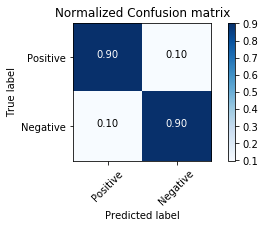

In [16]:
cnf_matrix = confusion_matrix(test_df['Rating'], the_prediction)         #compute confusion matrix
np.set_printoptions(precision=2)

plt.figure()
class_names = ['Positive', 'Negative']
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized Confusion matrix')     #create visualization of confusion matrix


### Soft Voting (Unresolved bug)

In [14]:
# soft_model = VotingClassifier(estimators = all_models, voting='soft')       #using the soft-voting classifier 
# soft_model.fit(X_train_new_entire, train_df['Rating'])                     #training the model


# test_df_new = tfidf_matrix2.transform(test_df['Reviews'])              #transform textual test data to numerical data
# the_prediction2 = soft_model.predict(test_df_new)        #run model on test dataset
# soft_Acc = accuracy_score(test_df['Rating'], the_prediction2)      #generate accuracy score of model
# print ("Accuracy for Soft Voting: %s" % (soft_Acc))


# <font color='blue'>Results</font>       

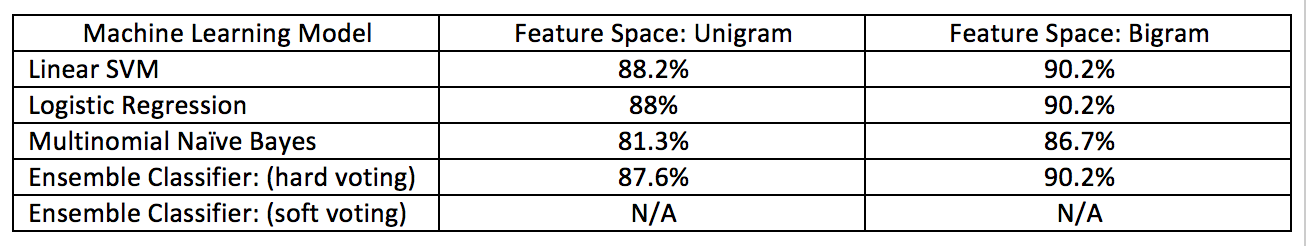

In [15]:
Image("images/resultsTable.png")

- From the table above we can see that SVM consistently outperformed all the other models, achieving 90.2%
- However, this does not suggest that SVM will always perform better.
- The other two models may perform better on smaller datasets that contain fewer sentences per review. 
- However, this analysis is currently out of scope and can be added to a future iteration of our project.
- The performance from Hard-Voting classifier was of no surprise as we knew that it was essentially a majority vote of the results from the models
- Unfortunately, due to time constraints we we're unable to resolve the issue of running Emsemble classifier with soft voting. The issue will be fixed in a future iteration.
- We also notice that adding bigrams always improved the performance, and gives better results than unigram. This seemingly reflects that in sentiment classification there are greater benefits from bigrams, because they can capture modified verbs and nouns.

# <font color='blue'>Analysis of the Results</font>       

- The image below are results from the paper http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf
- The 2011 paper ran binary classification on 3 datasets using a variety of feature spaces but we will focus on the “Our Dataset” column since it is identical to our dataset. We will specifically compare our results to the Bag of Words feature space in the first row where they scored 87.80%.
- The main difference between our approach and the 2011 paper approach was when it came to vectorization, they used the bag of words method whereas we used the TF-IDF method. Tf-idf allows us to quantify and identify signature words-something that is particularly useful for sentiment analysis. Whereas with bag of words we’re only considering the frequency of words in a document, with TF-idf we’re able to measure the importance of a word and take into consideration this importance of the word. (http://datameetsmedia.com/bag-of-words-tf-idf-explained/).
- As a result of this first step in the text analytics pipeline, we were able to achieve 90.2% accuracy on the same dataset that the 2011 paper achieved 87.80% on.


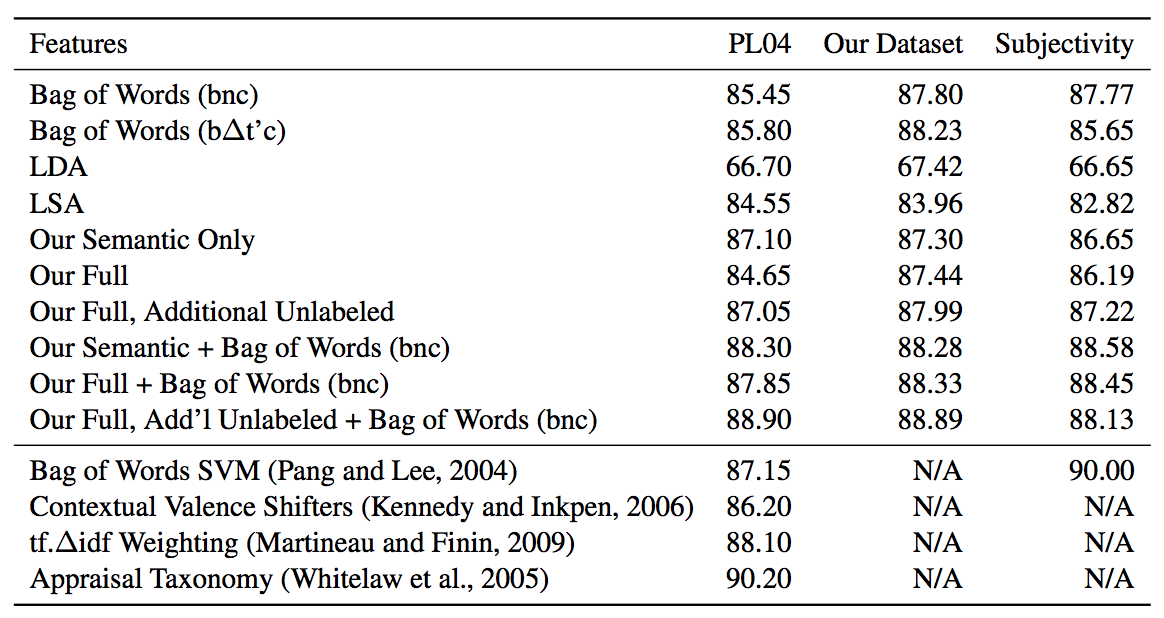

In [17]:
Image("images/paperResults.png")

# <font color='blue'>Future Work</font>

- Notice that in the 2011 paper they also experimented with unlabelled data which yielded the highest accuracy score of 88.89%
- This suggests that to improve our result, performing semi-supervised learning would with the provided unlabelled data would be our first priority
- Use sophisticated text preprocessing techniques, such as, Stemming and Lemmatization
- Perform text vectorization via Transfer Learning using Skip-Thought Vectors https://arxiv.org/abs/1506.06726
- Use the same classifiers, but experiment with a trigram model